In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller, acf, pacf
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("NLP_Dataset1.csv")

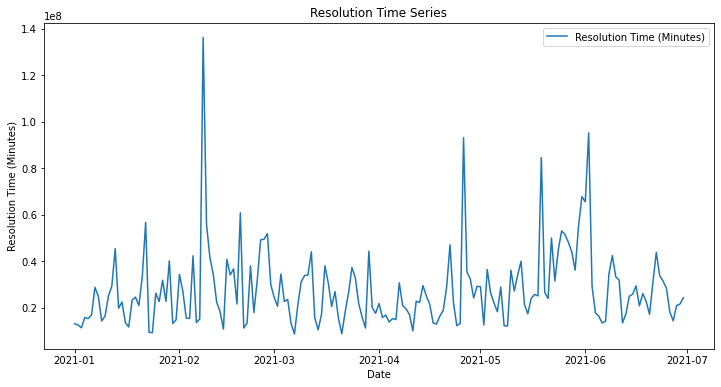

In [3]:
# Convert ActivatedTimestamp to datetime and set it as index
df['ActivatedTimestamp'] = pd.to_datetime(df['ActivatedTimestamp'])
df.set_index('ActivatedTimestamp', inplace=True)

# Resample by day and aggregate ResolutionTimeMinutes
df_resampled = df['ResolutionTimeMinutes'].resample('D').sum()

# Fill missing values
df_resampled = df_resampled.fillna(0)

#Plot the time series
plt.figure(figsize=(12, 6))
plt.plot(df_resampled, label='Resolution Time (Minutes)')
plt.title('Resolution Time Series')
plt.xlabel('Date')
plt.ylabel('Resolution Time (Minutes)')
plt.legend()
plt.show()

In [4]:
# Check for stationarity using ADF test
result = adfuller(df_resampled)
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Statistic: -2.7516866132006
p-value: 0.06551325018064548


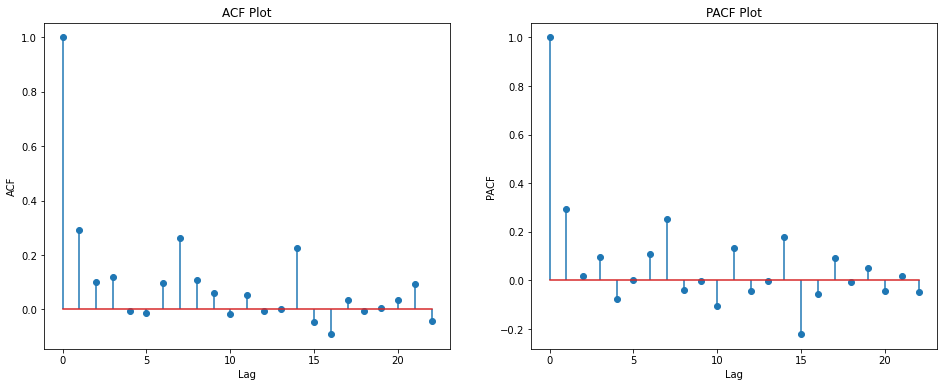

In [5]:
# Plot ACF and PACF
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
acf_vals = acf(df_resampled)
pacf_vals = pacf(df_resampled)

axes[0].stem(acf_vals, use_line_collection=True)
axes[0].set_title('ACF Plot')
axes[0].set_xlabel('Lag')
axes[0].set_ylabel('ACF')

axes[1].stem(pacf_vals, use_line_collection=True)
axes[1].set_title('PACF Plot')
axes[1].set_xlabel('Lag')
axes[1].set_ylabel('PACF')

plt.show()

In [6]:
# If data is not stationary, apply differencing
df_diff = df_resampled.diff().dropna()

# Check stationarity again after differencing
result = adfuller(df_diff)
print(f'ADF Statistic (after differencing): {result[0]}')
print(f'p-value (after differencing): {result[1]}')

ADF Statistic (after differencing): -4.680880881737049
p-value (after differencing): 9.139453631230255e-05


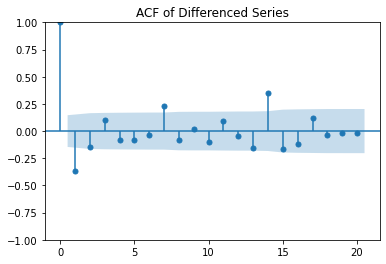

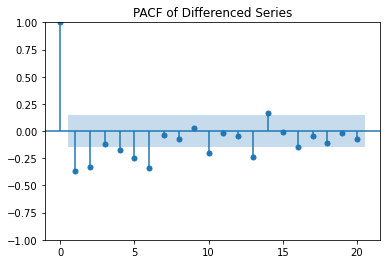

In [7]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# ACF plot
plot_acf(df_diff, lags=20)
plt.title('ACF of Differenced Series')
plt.show()

# PACF plot
plot_pacf(df_diff, lags=20)
plt.title('PACF of Differenced Series')
plt.show()

In [8]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Define the order and seasonal_order parameters based on previous analysis
order = (1, 1, 1)
seasonal_order = (1, 1, 1, 12)

# Fit SARIMAX model
model = SARIMAX(df_resampled, order=order, seasonal_order=seasonal_order)
results = model.fit()

# Print summary of the model
print(results.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.69960D+01    |proj g|=  7.25663D-02

At iterate    5    f=  1.69564D+01    |proj g|=  3.89918D-03


 This problem is unconstrained.



At iterate   10    f=  1.69560D+01    |proj g|=  6.36962D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     11     13      1     0     0   5.814D-06   1.696D+01
  F =   16.955973741957070     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
                                     SARIMAX Results                                      
Dep. Variable:              ResolutionTimeMinutes   No. Observations:                  181
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -3069.031
Date:                            Tue, 18 Jun 2024   AIC                           6148.0

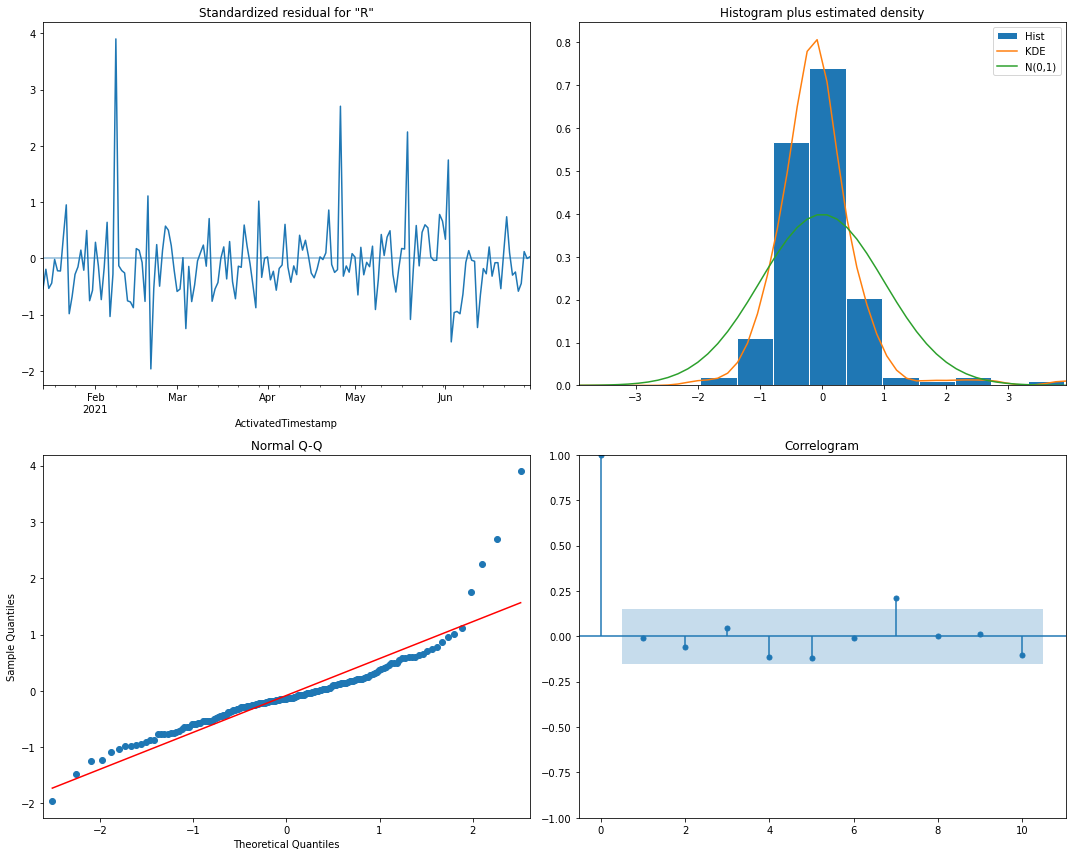

In [9]:
# Check diagnostics
results.plot_diagnostics(figsize=(15, 12))
plt.tight_layout()
plt.show()

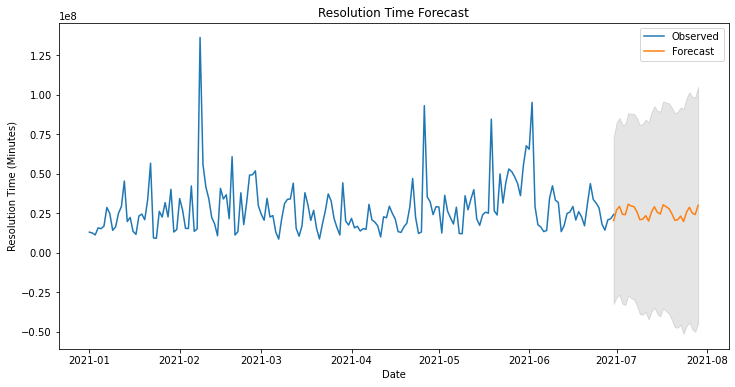

In [14]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Generate forecast steps
forecast_steps = 30

# Generate forecasts
forecast = results.get_forecast(steps=forecast_steps)
forecast_index = pd.date_range(start=df_resampled.index[-1], periods=forecast_steps, freq='D')

# Plot observed and forecasted values
plt.figure(figsize=(12, 6))
plt.plot(df_resampled.index, df_resampled, label='Observed')
plt.plot(forecast_index, forecast.predicted_mean.values, label='Forecast')

# Compute and plot confidence intervals
forecast_ci = forecast.conf_int()
plt.fill_between(forecast_index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='k', alpha=0.1)

plt.title('Resolution Time Forecast')
plt.xlabel('Date')
plt.ylabel('Resolution Time (Minutes)')
plt.legend()
plt.show()

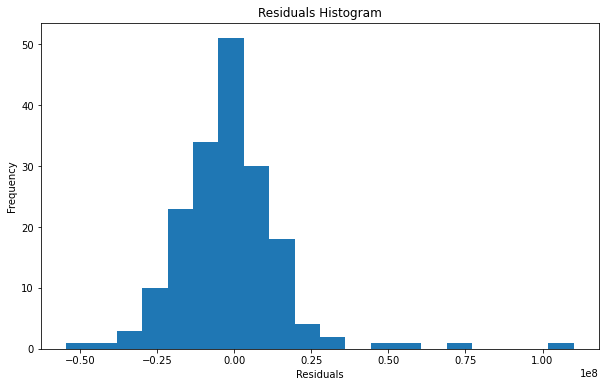

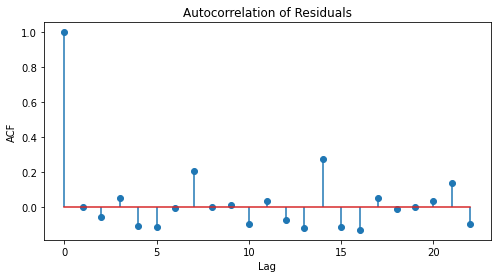

In [15]:
# Residual Analysis
residuals = results.resid
residuals.plot(kind='hist', bins=20, figsize=(10, 6))
plt.title('Residuals Histogram')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

# Plot autocorrelation of residuals
acf_resid = acf(residuals)
plt.figure(figsize=(8, 4))
plt.stem(acf_resid, use_line_collection=True)
plt.title('Autocorrelation of Residuals')
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.show()